In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os

Создание двух вычислительных графов:

In [2]:
a = tf.constant(1)
b = tf.constant(2)
c = tf.constant(3)

y1 = tf.add(a, b)
y2 = tf.multiply(c, b)
y3 = tf.pow(y2, 2)

print(y1.numpy())
print(y3.numpy())

3
36


Загрузка датасета MNIST и вывод информации о нем:

In [3]:
(data_train, data_test), data_info = tfds.load('mnist', split=['train', 'test'], with_info=True, as_supervised=True)
data_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\webma\\tensorflow_datasets\\mnist\\3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

Предобработка обучающего и тестового наборов данных:

In [4]:
batch_size = 100

# Загрузка данных в оперативную память
data_train = data_train.cache()
# Перемешивание данных
data_train = data_train.shuffle(data_info.splits['train'].num_examples)
# Объединение данных в пакеты
data_train = data_train.batch(batch_size)
# Предварительная подготовка следующих данных
data_train = data_train.prefetch(tf.data.AUTOTUNE)

data_test = data_test.batch(batch_size)
data_test = data_test.cache()
data_test = data_test.prefetch(tf.data.AUTOTUNE)

Функция построения модели нейронной сети:

In [5]:
def new_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=data_info.features['image'].shape, dtype=tf.float32),
        tf.keras.layers.Rescaling(scale=1./255),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(60, activation='relu'),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(10)])
    return model

In [6]:
checkpoint_path = "./lab3.ckpt"
log_path = "./logs/"
learning_rate = 0.05
num_epochs = 5

Стадия обучения модели на обучающем наборе данных:

In [7]:
train_summary_writer = tf.summary.create_file_writer(log_path)
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()

model = new_model()

cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

epoch_loss = tf.keras.metrics.Mean()
epoch_acc = tf.keras.metrics.SparseCategoricalAccuracy()

for epoch in range(num_epochs):
    epoch_loss.reset_state()
    epoch_acc.reset_state()
    steps = 0
    for image, label in data_train:
        steps += 1
        train_acc.reset_state()
        with tf.GradientTape() as tape:
            predicted_labels = model(image, training=True)
            loss = cce(label, predicted_labels)
            epoch_loss.update_state(loss)
            epoch_acc.update_state(label, predicted_labels)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_acc.update_state(label, predicted_labels)
        with train_summary_writer.as_default():
            # Сохранение сводных статистик для визуализации Tensorboard
            tf.summary.scalar('train_loss', loss, step=(epoch+1)*steps*batch_size)
            tf.summary.scalar('train_accuracy', train_acc.result(), step=(epoch+1)*steps*batch_size)
    print('Epoch: {}\tПотери: {}\tТочность: {}%'.format(epoch, epoch_loss.result(), epoch_acc.result()*100))

model.save_weights(checkpoint_path)
print('Обученная модель сохранена в файл: {}.index'.format(checkpoint_path))

Epoch: 0	Потери: 0.6197212338447571	Точность: 80.8566665649414%
Epoch: 1	Потери: 0.19984018802642822	Точность: 94.0999984741211%
Epoch: 2	Потери: 0.14387278258800507	Точность: 95.64833068847656%
Epoch: 3	Потери: 0.11261340975761414	Точность: 96.6483383178711%
Epoch: 4	Потери: 0.09044107794761658	Точность: 97.26667022705078%
Обученная модель сохранена в файл: ./lab3.ckpt.index


In [8]:
%load_ext tensorboard

Восстановление обученной модели из файла и ее тестирование на тестовом наборе данных:

In [9]:
model = new_model()

untrain_acc = tf.keras.metrics.SparseCategoricalAccuracy()

for image, label in data_test:
    predicted_labels = model(image, training=False)
    untrain_acc.update_state(label, predicted_labels)
    
print('Необученная модель. Точность: {}%'.format(untrain_acc.result()*100))

if os.path.isfile(checkpoint_path + '.index'):
    model.load_weights(checkpoint_path)
    print('Модель восстановлена из файла: ', checkpoint_path)
    
test_summary_writer = tf.summary.create_file_writer(log_path)
loaded_acc = tf.keras.metrics.SparseCategoricalAccuracy()
curr_acc = tf.keras.metrics.SparseCategoricalAccuracy()

steps = 0
for image, label in data_test:
    steps += 1
    curr_acc.reset_state()
    predicted_labels = model(image, training=False)
    loaded_acc.update_state(label, predicted_labels)
    curr_acc.update_state(label, predicted_labels)
    with test_summary_writer.as_default():
        tf.summary.scalar('test_accuracy', curr_acc.result(), step=steps*batch_size)
    
print('Обученная модель. Точность: {}%'.format(loaded_acc.result()*100))

Необученная модель. Точность: 11.069999694824219%
Модель восстановлена из файла:  ./lab3.ckpt
Обученная модель. Точность: 97.06999969482422%


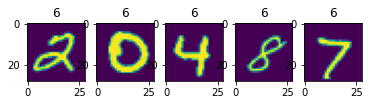

In [10]:
empty_model = new_model()
taked = data_test.take(1)
fig, axs = plt.subplots(1, 5)

for images, _ in taked:
    predicted_labels = empty_model(images, training=False)
    for i in range(5):
        axs[i].imshow(images[i])
        axs[i].set_title(np.argmax(predicted_labels[i]))
plt.show()

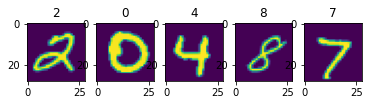

In [11]:
fig, axs = plt.subplots(1, 5)

for images, _ in taked:
    predicted_labels = model(images, training=False)
    for i in range(5):
        axs[i].imshow(images[i])
        axs[i].set_title(np.argmax(predicted_labels[i]))
plt.show()